# Importing libraries

In [3]:
import pandas as pd
import numpy as np

from math import ceil, floor
pd.set_option('display.max_columns', None)
print("Done")

Done


# Setup experiment parameters

In [4]:
# Used all orders to train
use_all_orders = True

# Reading input data

In [5]:
# Reading input sheets as dataframes
items_df = pd.read_csv('Output_v2/items.csv', sep=';')
orders_df = pd.read_csv('Output_v2/orders.csv', sep=';')
output_df = pd.read_csv('Output_v2/orders_output.csv', sep=';', dtype={'pallet_id': str})
pallets_df = pd.read_excel('Output_v2/pallet_types.xlsx')
current_sizes_arr = pd.read_excel('Output_v2/currently_produced_sizes.xlsx')['currently_produced_sizes'].unique()
print("Done")

Done


In [6]:
# SISTEMAZIONE DATI
column_da_modificare = ['kgxsc', 'exsz', 'x_mm', 'y_mm', 'z_mm', 'z_frd_mm', 'kgxfrd', 'kgxplt', 'x_sc_mm', 'y_sc_mm', 'z_sc_mm', 'pzxsc', 'x_frd_mm', 'y_frd_mm', 'scxfrd', 'z_cub_mm', 'scxpl']
for column in items_df.columns:
    if column in column_da_modificare:
        items_df[column] = items_df[column].astype(str).str.replace(",", ".").astype(float)
items_df['exsz'] = items_df['exsz'].astype(int)
items_df['x_mm'] = items_df['x_mm'].astype(int)
items_df['y_mm'] = items_df['y_mm'].astype(int)
items_df['z_mm'] = items_df['z_mm'].astype(int)
items_df['pzxsc'] = items_df['pzxsc'].astype(int)
items_df['x_sc_mm'] = items_df['x_sc_mm'].astype(int)
items_df['y_sc_mm'] = items_df['y_sc_mm'].astype(int)
items_df['x_frd_mm'] = items_df['x_frd_mm'].astype(int)
items_df['y_frd_mm'] = items_df['y_frd_mm'].astype(int)
items_df['z_cub_mm'] = items_df['z_cub_mm'].astype(int)
items_df['scxpl'] = items_df['scxpl'].astype(int)
orders_df['pieces'] = orders_df['pieces'].astype(str).str.replace(",", ".").astype(float).astype(int)
output_df['pieces'] = output_df['pieces'].astype(str).str.replace(",", ".").astype(float)
print("Done")

Done


## Splitting extra-size pallet from normal pallet


In [7]:
# Splitting pallets df into normal and extra size
pallet_extra_size = pallets_df[pallets_df['extra_size'] > 0]
pallet_normal_size = pallets_df[pallets_df['extra_size'] == 0]

pallet_normal_size

,cdsup,x_mm,y_mm,used_for_shipping,z_mm,max_weight,max_height,extra_size,volume
0,F,800,1200,1,134,1300,1000,0,960000000
1,AF,800,1200,1,134,700,1000,0,960000000
2,X,910,1240,1,139,1300,1000,0,1128400000
7,B,1010,1200,1,134,1300,1000,0,1212000000
8,U,800,1200,1,132,1300,1000,0,960000000
10,E,800,1200,1,144,1300,1000,0,960000000
11,C,940,940,0,135,1200,1000,0,883600000
12,AA,850,1200,0,135,1200,1000,0,1020000000
13,W,870,123,0,141,1300,1000,0,107010000
14,9,800,1200,0,134,1200,1000,0,960000000


## Processing input data
### Splitting extra size from normal size

In [8]:
# Get all item sizes
item_sizes = [sz.replace(',', '.') for sz in items_df['defom'].unique()]

# Get all item sizes currently produced
current_sizes = [sz for sz in item_sizes if sz in current_sizes_arr]

# Get all item sizes not being produced
not_produced_sizes = [sz for sz in item_sizes if sz not in current_sizes_arr]

# Get all item thicknesses
item_thickness = items_df['z_mm'].unique()

# Get production pallet types
prod_pallet_types = items_df['cdsup'].unique()

# Get maximum pallet weight and volume for each type of pallets
pallet_extra_size.loc[:, 'volume'] = pallet_extra_size['x_mm'] * pallet_extra_size['y_mm'] * pallet_extra_size['max_height']
pallet_normal_size.loc[:,'volume'] = pallet_normal_size['x_mm'] * pallet_normal_size['y_mm'] * pallet_normal_size['max_height']
shipping_pallets_extra = pallet_extra_size[pallet_extra_size['used_for_shipping'] == 1]
shipping_pallets_normal = pallet_normal_size[pallet_normal_size['used_for_shipping'] == 1]


max_pallet_extra_weight = shipping_pallets_extra['max_weight'].max()
max_pallet_extra_volume = shipping_pallets_extra['volume'].max()

max_pallet_normal_weight = shipping_pallets_normal['max_weight'].max()
max_pallet_normal_volume = shipping_pallets_normal['volume'].max()
print("Done")

Done


In [9]:
# Check
shipping_pallets_extra

,cdsup,x_mm,y_mm,used_for_shipping,z_mm,max_weight,max_height,extra_size,volume
3,H,1230,1430,1,149,1200,1000,1,1758900000
4,HA,1230,1230,1,149,700,1000,1,1512900000
5,DA,775,1520,1,170,500,1000,1,1178000000
6,D,775,1520,1,170,1200,1000,1,1178000000
9,Z,1160,1300,1,141,1300,1000,1,1508000000


In [10]:
# Function used to extract features of an item
def get_item_attr(row):
    
    # Dictionary with the attributes of the item
    attr = {
        'item': row['item_id'],
        'size': row['defom'].replace(',', '.'),
        'thickness': row['z_mm'],
        'special': row['exsz'],
        'weight': row['kgxsc'] / row['pzxsc'],
        'volume': row['x_mm'] * row['y_mm'] * row['z_mm'],
        'pieces_x_box': row['pzxsc'],
        'boxes_x_bundle': row['scxfrd'],
        'bundles_x_fullpallet': row['frdxplt'],
        'pieces_x_fullpallet': int(row['pzxsc']) * int(row['scxpl']),
        'pallet': row['cdsup']
    }

    return attr


# Extracting the attributes of each item
items_attr = pd.DataFrame(
    items_df.apply(
        lambda row : get_item_attr(row), 
        axis=1
).tolist())

# Remove duplicates from dataset
items_attr = items_attr.drop_duplicates(subset='item', keep='first')

# Set item ID as dataframe index
items_attr.set_index('item', inplace=True)
items_attr

,size,thickness,special,weight,volume,pieces_x_box,boxes_x_bundle,bundles_x_fullpallet,pieces_x_fullpallet,pallet
item,,,,,,,,,,
23240f8293 N 048,30X30,8,0,1.675000,720000,12,0.0,inf,576,9
23240f8293 S 048,30X30,8,0,1.675000,720000,12,2.0,24,576,F
a9245b804a E 048,30X30,8,0,1.675000,720000,12,0.0,inf,576,9
a9245b804a S 048,30X30,8,0,1.675000,720000,12,2.0,24,576,F
5274764a88 E 048,30X30,8,0,1.675000,720000,12,0.0,inf,576,9
...,...,...,...,...,...,...,...,...,...,...
760d5474d2 S 048,80X80,9,1,13.300000,5760000,2,8.0,6,96,X
634b27b9b9 S 040,60X60,9,0,7.076667,3240000,3,4.0,10,120,F
7a5007badc S 040,30X30,9,0,1.780000,810000,11,0.0,inf,440,9


In [11]:
# Function used to extract features from an item in an order
def get_order_item_attr(row, items_attr, item_sizes, item_thickness, prod_pallet_types):

    # Dictionary with the attributes of the order item
    attr = { 'errors': 0 }

    # Order number
    attr['order'] = row['order_number']

    # Homogeneous and fullorder data
    attr['homogeneous_order'] = row['homogeneous_order']
    attr['full_order'] = row['full_order']

    # Add flag to filter if item does not exists
    if row['item_id'] not in items_attr.index:
        attr['errors'] = 1
        return attr

    # Get corresponding item data
    item = items_attr.loc[row['item_id']]

    # Quantity of the item in the order
    pieces = row['pieces']

    # One-hot encoding for size types
    for size in item_sizes:

        quant = (pieces if size == item['size'] else 0)

        attr[size] = quant
        # attr[size + '_weight'] = quant * item['weight']
        # attr[size + '_volume'] = quant * item['volume']
        # attr[size + '_special'] = quant * item['special']

    # Total pieces
    attr['pieces'] = pieces

    # Total weight
    attr['weight'] = pieces * item['weight']

    # Total volume
    attr['volume'] = pieces * item['volume']

    # Upper bound
    attr['HS'] = pieces / item['pieces_x_fullpallet']

    return attr

# Extracting the attributes of each item of the order (removing invalid orders)
order_items_attr = pd.DataFrame(
    orders_df.dropna().apply(
        lambda row : get_order_item_attr(row, items_attr, item_sizes, item_thickness, prod_pallet_types),
        axis=1
).tolist())

order_items_attr

,errors,order,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
0,0,OBD0000497747,0,1,0.0,0.0,0.0,0.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,432.0,1814.40,7.873200e+08,2.000000
1,0,OBD0000452706,1,1,0.0,0.0,320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,1040.00,4.608000e+08,1.000000
2,0,OBD0000367775,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,5493.76,2.349000e+09,6.628571
3,0,OBD0000381748,0,0,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,560.28,2.721600e+08,0.700000
4,0,OBD0000677472,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,2320.00,1.036800e+09,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563236,0,OBD0000778485,0,0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,129.42,5.832000e+07,0.150000
563237,0,OBD0000937036,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,9.0,84.00,4.320000e+07,0.085714
563238,0,OBD0000759596,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,112.00,5.760000e+07,0.114286
563239,0,OBD0000922074,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,30.00,1.296000e+07,0.028571


In [12]:
order_items_attr[order_items_attr['errors'] > 0]

,errors,order,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
168,1,OBD0000765285,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,1,OBD0000791436,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,1,OBD0000842783,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2917,1,OBD0000373050,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3395,1,OBD0000892125,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552595,1,OBD0000511648,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553438,1,OBD0000813730,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555362,1,OBD0000559770,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557957,1,OBD0000360448,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Group items data by order ID
orders_group = order_items_attr.groupby('order')
orders_attr = orders_group.sum()
orders_attr['HS'] = np.ceil(orders_attr['HS'])
orders_attr

,errors,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0
OBD0000222317,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0
OBD0000237609,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0
OBD0000252157,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0
OBD0000262533,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0
OBD0000964336,0,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0
OBD0000964548,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0


In [12]:
orders_attr[orders_attr['errors'] > 0]

,errors,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000324756,1,0,0,0.0,0.0,448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,448.0,1590.40,7.257600e+08,2.0
OBD0000329415,1,0,0,0.0,0.0,903.0,144.0,0.0,0.0,24.0,266.0,0.0,0.0,0.0,224.0,0.0,0.0,60.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,384.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,2278.0,14340.33,6.587465e+09,16.0
OBD0000330991,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,595.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,713.0,21658.25,9.361575e+09,19.0
OBD0000332907,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
OBD0000334315,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000935488,1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,216.0,0.0,0.0,0.0,0.0,0.0,216.0,1076.40,4.665600e+08,1.0
OBD0000938267,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0
OBD0000939209,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.0


In [14]:
# Remove orders with errors
orders_attr = orders_attr[orders_attr['errors'] == 0].drop('errors', axis=1)
orders_attr

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0


In [15]:
# Compute averages
orders_attr['weight_avg'] = orders_attr['weight'] / orders_attr['pieces']
orders_attr['volume_avg'] = orders_attr['volume'] / orders_attr['pieces']

# Compute lower bound for each type of pallet
weight_lb_extra = np.ceil(orders_attr['weight'] / max_pallet_extra_weight)
volume_lb_extra = np.ceil(orders_attr['volume'] / max_pallet_extra_volume)
weight_lb_normal = np.ceil(orders_attr['weight'] / max_pallet_normal_weight)
volume_lb_normal = np.ceil(orders_attr['volume'] / max_pallet_normal_volume)

#orders_attr['HS1'] = pd.merge(weight_lb_extra, volume_lb_extra, on='order').max(axis=1)
orders_attr

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0


## Model with extra_size pallets

In [18]:
# Escludi i pallet di shipping_pallets_extra
output_no_duplicates = output_df[output_df['pallet_type'].isin(shipping_pallets_extra['cdsup'])]\
    .drop_duplicates(subset=['order_number', 'pallet_id'])

# Raggruppa per numero d'ordine e conta i pallet normali
output_pallet_freq_extra = output_no_duplicates.groupby('order_number').size().reset_index(name='pallets_extra_used')

# Assicurati che tutti gli ordini siano presenti, anche quelli con zero pallet normali
output_pallet_freq_extra = output_df[['order_number']].drop_duplicates().merge(output_pallet_freq_extra, on='order_number', how='left').fillna({'pallets_extra_used': 0})

# Imposta l'indice su order_number
output_pallet_freq_extra.set_index('order_number', inplace=True)

output_pallet_freq_extra

,pallets_extra_used
order_number,
OBD0000746845,1.0
OBD0000841197,0.0
OBD0000360306,0.0
OBD0000928099,0.0
OBD0000579526,0.0
...,...
OBD0000519187,0.0
OBD0000389805,3.0
OBD0000443227,3.0


In [19]:
output_df[(output_df.homogeneous_order == 0) & (output_df.full_order == 0)]

,order_number,pallet_id,pallet_type,full_pallet,item,item_size,batch,pieces,homogeneous_order,full_order
2,OBD0000360306,59768667,AF,0,f9f6e65d15,60X60,1 NA6 8=,12.0,0,0
3,OBD0000360306,59768667,AF,0,f32834da75,40X80,1 AD4 =,56.0,0,0
6,OBD0000580010,51357641,AF,0,598c33f127,40X80,1 6AA =,20.0,0,0
7,OBD0000580010,51929111,X,0,433cce938e,60X120,1 DF6 5,46.0,0,0
54,OBD0000754838,51827014,AF,0,1a5f51c126,50X120,1 AQ4 5=,33.0,0,0
...,...,...,...,...,...,...,...,...,...,...
1131675,OBD0000436088,85398232,F,1,7a4675a302,30X60,1 FD7 4=,320.0,0,0
1131676,OBD0000436088,85398249,F,1,7a4675a302,30X60,1 FD7 4=,320.0,0,0
1131677,OBD0000436088,85398252,F,1,7a4675a302,30X60,1 FD7 4=,320.0,0,0
1131678,OBD0000436088,85449426,F,1,7a4675a302,30X60,1 FD7 4=,320.0,0,0


In [20]:
output_df[output_df.pieces == 1]

,order_number,pallet_id,pallet_type,full_pallet,item,item_size,batch,pieces,homogeneous_order,full_order
1796,OBD0000368946,51279588,D,0,115f71fa45,75X150,1 EA6 8,1.0,0,0
1798,OBD0000380799,51279749,D,0,115f71fa45,75X150,1 EA6 8,1.0,1,0
2652,OBD0000367814,60998096,F,0,2006ce3868,50X120,1 AA6 =,1.0,0,0
3631,OBD0000668512,59257854,H,0,4a3fbbd012,120X120 SP,1 FF6 5=,1.0,0,0
4948,OBD0000369169,51376119,D,0,20fb35895a,75X150,1 AA4 5,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...
1125779,OBD0000916992,52952957,AF,0,2616403a20,50X120,1 AA5 5,1.0,0,0
1125785,OBD0000436881,60780142,H,0,766d54f115,120X120,1 CP6 5=,1.0,0,0
1126125,OBD0000661985,52190747,AF,0,558d11aed7,60X120,1 NP4S5,1.0,0,0
1126126,OBD0000661985,52190931,AF,0,558d11aed7,60X120,1 NP4S5,1.0,0,0


## Model with normal_size pallets

In [21]:
# Escludi i pallet di shipping_pallets_extra
output_no_duplicates = output_df[~output_df['pallet_type'].isin(shipping_pallets_extra['cdsup'])]\
    .drop_duplicates(subset=['order_number', 'pallet_id'])

# Raggruppa per numero d'ordine e conta i pallet normali
output_pallet_freq_normal = output_no_duplicates.groupby('order_number').size().reset_index(name='pallets_normal_used')

# Assicurati che tutti gli ordini siano presenti, anche quelli con zero pallet normali
output_pallet_freq_normal = output_df[['order_number']].drop_duplicates()\
    .merge(output_pallet_freq_normal, on='order_number', how='left')\
    .fillna({'pallets_normal_used': 0})

# Imposta l'indice su order_number
output_pallet_freq_normal.set_index('order_number', inplace=True)

output_pallet_freq_normal

,pallets_normal_used
order_number,
OBD0000746845,0.0
OBD0000841197,1.0
OBD0000360306,1.0
OBD0000928099,1.0
OBD0000579526,1.0
...,...
OBD0000519187,1.0
OBD0000389805,0.0
OBD0000443227,0.0


In [22]:
# Merge the attributes and outputs of the order
model_input_extra = orders_attr.merge(output_pallet_freq_extra, left_index=True, right_index=True)
model_input_normal = orders_attr.merge(output_pallet_freq_normal, left_index=True, right_index=True)

In [23]:
def filter_orders_with_not_produced_sizes(df, not_produced_sizes):
    
    df = df[df[not_produced_sizes].eq(0).all(axis=1)]

    # Remove columns of unused sizes
    df = df.drop(columns=not_produced_sizes, axis=1)

    return df

# filter for input and extra
model_input_extra = filter_orders_with_not_produced_sizes(model_input_extra, not_produced_sizes)
model_input_normal = filter_orders_with_not_produced_sizes(model_input_normal, not_produced_sizes)

In [24]:
# Get attributes of the box of each size
box_attr = {}

for sz in item_sizes:
    if not items_df[items_df['defom'] == sz].empty:
        # Get first entry
        row = items_df[items_df['defom'] == sz].iloc[0]

        box_attr[sz] = {
            'x': row['x_sc_mm'],
            'y': row['y_sc_mm'],
            'z': row['z_sc_mm'],
            'area': row['x_sc_mm'] * row['y_sc_mm'],
            'weight': row['kgxsc'],
            'pieces_x_box': row['pzxsc']
    }
    
# Sort sizes by box area
sorted_sizes = sorted(item_sizes, key=lambda sz:box_attr[sz]['area'], reverse=True)

#valid_pallets_df = pallets_df[pallets_df['used_for_shipping'] == 1]

# Get pallet type with highest weight limit
#max_weight_pallet = valid_pallets_df.loc[valid_pallets_df['max_weight'].idxmax()]

In [25]:
max_pallet_extra = {'max_weight': max_pallet_extra_weight, 'max_height':1000}
max_pallet_normal = {'max_weight': max_pallet_normal_weight, 'max_height':1000}

In [26]:
# Heuristic pallet estimation
def reset_pallet(pallet_attr):
    # return pallet_attr['x_mm'], pallet_attr['y_mm'], 0, 0
    return 1230, 1520, 0, 0,

def try_pack(boxes, box_x, box_y, pallet_x, pallet_y):

    # Maximum boxes in x and y dimension
    max_x = min(boxes, floor(pallet_x / box_x))
    max_y = min(boxes, floor(pallet_y / box_y))

    best_quant = 0
    best_x = 0
    best_y = 0

    # Check all x values for the best
    for x in range(1, max_x + 1):
        
        y = min(max_y, ceil(boxes / x))
        quant = min(boxes, x * y)

        if quant < best_quant:
            continue
        if (x * box_x * y * box_y) < (best_x * best_y):
            continue

        best_quant = quant
        best_x = x * box_x
        best_y = y * box_y

    return best_quant, best_x, best_y
    

def pallet_heuristic(row, item_sizes, box_attr, pallet_attr):

    num_sizes = len(item_sizes)
    pallets = 0

    must_reset = True
    
    for sz in item_sizes:

        tiles = row.get(sz, 0)
        total_boxes = ceil(tiles / box_attr[sz]['pieces_x_box'])

        while total_boxes > 0:

            if must_reset:
                must_reset = False
                cur_x, cur_y, cur_weight, cur_height = reset_pallet(pallet_attr)
                pallets += 1
            
            if cur_height + box_attr[sz]['z'] > pallet_attr['max_height']: # max pallet height
                must_reset = True
                continue
                
            if cur_weight + box_attr[sz]['weight'] > pallet_attr['max_weight']:
                must_reset = True
                continue

            # Check how many boxes based on weight
            cur_boxes = min(total_boxes, floor((pallet_attr['max_weight'] - cur_weight) / box_attr[sz]['weight']))

            # Try packing horizontal
            quant, x, y = try_pack(cur_boxes, box_attr[sz]['x'], box_attr[sz]['y'], cur_x, cur_y)

            # Try packing vertical
            quant2, x2, y2 = try_pack(cur_boxes, box_attr[sz]['y'], box_attr[sz]['x'], cur_x, cur_y)

            if quant < quant2 or (quant == quant2 and x * y < x2 * y2):
                quant = quant2
                x = x2
                y = y2

            # No boxes can be packed
            if quant == 0:
                must_reset = True
                continue
            
            # Pack boxes
            total_boxes -= quant
            cur_height += box_attr[sz]['z']
            cur_weight += quant * box_attr[sz]['weight']
            cur_x = x
            cur_y = y

    return pallets

'''
model_input_extra['HS3'] = model_input_extra.apply(
    lambda row:pallet_heuristic(row, sorted_sizes, box_attr, max_pallet_extra),
    axis=1
)
model_input_normal['HS3'] = model_input_normal.apply(
    lambda row:pallet_heuristic(row, sorted_sizes, box_attr, max_pallet_normal),
    axis=1
)
'''
model_input_extra

,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallets_extra_used
OBD0000172580,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1160.00,5.184000e+08,1.0,29.000000,12960000.0,1.0
OBD0000222317,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,68.00,3.037500e+07,1.0,11.333333,5062500.0,0.0
OBD0000237609,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,78.0,388.70,1.684800e+08,1.0,4.983333,2160000.0,0.0
OBD0000252157,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,59.80,2.592000e+07,1.0,4.983333,2160000.0,0.0
OBD0000262533,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.00,1.012500e+07,1.0,22.000000,10125000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000964296,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,331.52,1.417500e+08,1.0,23.680000,10125000.0,1.0
OBD0000964336,1,1,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,4200.00,1.814400e+09,4.0,15.000000,6480000.0,0.0
OBD0000964548,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,174.00,7.776000e+07,1.0,29.000000,12960000.0,1.0
OBD0000964597,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,56.00,2.880000e+07,1.0,9.333333,4800000.0,0.0


# Split homogeneous and full orders

In [27]:
model_input_other_e = model_input_extra[(model_input_extra['homogeneous_order'] == 0) & (model_input_extra['full_order'] == 0)]
model_input_hf_e = model_input_extra[(model_input_extra['homogeneous_order'] > 0) | (model_input_extra['full_order'] > 0)]

## Now for normal size pallets

In [28]:
model_input_other_n = model_input_normal[(model_input_normal['homogeneous_order'] == 0) & (model_input_normal['full_order'] == 0)]
model_input_hf_n = model_input_normal[(model_input_normal['homogeneous_order'] > 0) | (model_input_normal['full_order'] > 0)]

## Possible params for algorithms

In [29]:
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from catboost import CatBoostRegressor

algorithms = [
    {
        'name': 'xgboost',
        'model': xgb.XGBRegressor(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'gamma': [0, 0.1, 0.5],
            'max_depth': [3, 6, 10],
            'min_child_weight': [0, 1, 3, 5],
            'subsample': [0.5, 1],
            'colsample_bytree': [0.5, 1]
        }
    },
    {
        'name': 'lgbm',
        'model': lgbm.LGBMRegressor(verbosity=-1),
        'params': {
            'learning_rate': [0.005, 0.01],
            'num_leaves': [6,8,12,16]
        }
    },
    {
        'name': 'random-forest',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [3, 6, 9],
            'max_leaf_nodes': [3, 6, 9]
        }
    },
        {
        'name': 'catboost',
        'model': CatBoostRegressor(silent=True, random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1],
            'depth': [4, 8],
            'l2_leaf_reg': [1, 5, 7],
            'bagging_temperature': [0, 3],
            'random_strength': [0.5, 1]
        }
    }
]

# Build train, test, prediction datasets for extra size pallets

## Converting input and Grid Search

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from time import time
import sys

# Split H and F orders
train_input_hf, test_input_hf = train_test_split(model_input_hf_e, test_size=0.2, train_size=0.8, random_state=42)

# Split other orders
train_input_other, test_input_other = train_test_split(model_input_other_e, test_size=0.2, train_size=0.8, random_state=42)

# Convert input to models to x and y format
def convert_input(input_df):
    # Get only pallets used
    y = input_df['pallets_extra_used'].values

    # Get the rest of columns and drop filter columns
    x = input_df.drop(columns=['pallets_extra_used', 'homogeneous_order', 'full_order'])

    return x, y

# Select all orders or only hard orders to train
if use_all_orders:
    train_input = pd.concat([train_input_hf, train_input_other])
else:
    train_input = train_input_other.copy()

# Only hard orders will be used for testing
test_input = test_input_other.copy()

X_train, y_train = convert_input(train_input)
X_test, y_test = convert_input(test_input)

algorithms_extra = algorithms.copy()

for alg in algorithms_extra:
    # Grid search
    start = time()
    # Grid search
    cv = GridSearchCV(alg['model'], alg['params'], scoring='neg_mean_squared_error', n_jobs=4, cv=5, verbose=1)
    cv.fit(X_train, y_train)
    sys.stdout.flush()
    # Get best parameters
    best_params = cv.best_params_
    end = time()
    # Get best parameters
    alg['train_time'] = end - start

    # Get best parameters
    alg['best_params'] = cv.best_params_

    # Get best trained model
    alg['best_model'] = cv.best_estimator_

    # Save result
    alg['cv_results'] = cv.cv_results_

print(f"Time: {alg['train_time']}\n")

for alg in algorithms_extra:
    print(alg['name'], ':', alg['best_params'])

import pickle

# Save models
for alg in algorithms_extra:

    name = alg['name']

    if use_all_orders:
        name += '_all'
    else:
        name += '_filter'

    with open(f"models/extra_{name}.pkl", 'wb') as file:
        pickle.dump(alg['best_model'], file)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Time: 3810.8440203666687

xgboost : {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 0, 'subsample': 1}
lgbm : {'learning_rate': 0.01, 'num_leaves': 16}
random-forest : {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9}
catboost : {'bagging_temperature': 0, 'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_strength': 0.5}


In [38]:
X_train

,errors,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg
OBD0000673901,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,43.80,2.459520e+07,1.0,2.433333,1.366400e+06
OBD0000456686,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,296.00,1.296000e+08,1.0,18.500000,8.100000e+06
OBD0000548739,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,763.20,4.608000e+08,1.0,5.300000,3.200000e+06
OBD0000846763,0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,312.00,1.382400e+08,1.0,3.250000,1.440000e+06
OBD0000917320,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,94.72,4.050000e+07,1.0,23.680000,1.012500e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000610788,0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,55.0,638.00,3.009600e+08,1.0,11.600000,5.472000e+06
OBD0000367731,0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,99.0,574.99,2.559600e+08,1.0,5.807980,2.585455e+06
OBD0000762233,0,0.0,0.0,48.0,0.0,273.0,6.0,0.0,0.0,0.0,0.0,0.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1027.0,4525.15,2.342260e+09,5.0,4.406183,2.280682e+06
OBD0000326827,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,1369.55,6.147900e+08,2.0,10.616667,4.765814e+06


In [25]:
test_data_e = []

for alg in algorithms_extra:

    # Get model
    model = alg['best_model']

    # Make prediction
    y_predict = model.predict(X_test)

    y_predict = np.round(y_predict).astype(int)
    # y_predict = np.floor(y_predict).astype(int)
    # y_predict = np.ceil(y_predict).astype(int)

    test_data_e.append([
        alg['name'],
        mse(y_test, y_predict),
        rmse(y_test, y_predict),
        mae(y_test, y_predict)
    ])

test_results = pd.DataFrame(test_data_e, columns=['model', 'MSE', 'RMSE', 'MAE'])
test_results

,model,MSE,RMSE,MAE
0,xgboost,0.153061,0.391230,0.079278
1,lgbm,1.362507,1.167265,0.353087
2,random-forest,1.477957,1.215712,0.506345
3,catboost,0.132195,0.363587,0.071363


# Build train, test, prediction datasets for normal size pallets

## Converting input and Grid Search

In [31]:
from time import time
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

algorithms_normal = algorithms.copy()
# Split H and F orders
train_input_hf_n, test_input_hf_n = train_test_split(model_input_hf_n, test_size=0.2, train_size=0.8, random_state=42)

# Split other orders
train_input_other_n, test_input_other_n = train_test_split(model_input_other_n, test_size=0.2, train_size=0.8, random_state=42)

# Convert input to models to x and y format
def convert_input(input_df):
    # Get only pallets used
    y = input_df['pallets_normal_used'].values

    # Get the rest of columns and drop filter columns
    x = input_df.drop(columns=['pallets_normal_used', 'homogeneous_order', 'full_order'])

    return x, y

# Select all orders or only hard orders to train
if use_all_orders:
    train_input_n = pd.concat([train_input_hf_n, train_input_other_n])
else:
    train_input_n = train_input_other_n.copy()

# Only hard orders will be used for testing
test_input_n = test_input_other_n.copy()

X_train_n, y_train_n = convert_input(train_input_n)
X_test_n, y_test_n = convert_input(test_input_n)

for alg in algorithms_normal:
    # Grid search
    start = time()
    cv = GridSearchCV(alg['model'], alg['params'], scoring='neg_mean_squared_error', n_jobs=4, cv=5, verbose=1)
    cv.fit(X_train_n, y_train_n)
    sys.stdout.flush()
    end = time()
    # Get best parameters
    best_params = cv.best_params_
    alg['train_time'] = end - start

    # Get best parameters
    alg['best_params'] = cv.best_params_

    # Get best trained model
    alg['best_model'] = cv.best_estimator_

    # Save result
    alg['cv_results'] = cv.cv_results_

print(f"Time: {alg['train_time']}\n")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Time: 3775.3080554008484



In [32]:
for alg in algorithms_normal:
    print(alg['name'], ':', alg['best_params'])

import pickle

# Save models
for alg in algorithms_normal:
    name = alg['name']

    if use_all_orders:
        name += '_all'
    else:
        name += '_filter'

    with open(f"models/normal_{name}.pkl", 'wb') as file:
        pickle.dump(alg['best_model'], file)

xgboost : {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5}
lgbm : {'learning_rate': 0.01, 'num_leaves': 16}
random-forest : {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9}
catboost : {'bagging_temperature': 0, 'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_strength': 1}


In [42]:
'''model.fit(X_train_n, y_train_n)

# Make prediction
y_predict_n = model.predict(X_test_n)

y_predict_n = np.round(y_predict_n).astype(int)
# y_predict = np.floor(y_predict).astype(int)
# y_predict = np.ceil(y_predict).astype(int)

test_data_n = {'mse': mse(y_test_n, y_predict_n), 'rmse': rmse(y_test_n, y_predict_n),'mae': mae(y_test_n, y_predict_n)}
test_results_n = pd.DataFrame(test_data_n, columns=['MSE', 'RMSE', 'MAE'])
test_data_n'''

{'mse': 1.028053235908142,
 'rmse': 1.0139296010612089,
 'mae': 0.39091858037578286}

In [33]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

test_data_n = []

for alg in algorithms_normal:

    # Get model
    model = alg['best_model']

    # Make prediction
    y_predict_n = model.predict(X_test_n)

    y_predict_n = np.round(y_predict_n).astype(int)
    # y_predict = np.floor(y_predict).astype(int)
    # y_predict = np.ceil(y_predict).astype(int)

    test_data_n.append([
        alg['name'],
        mse(y_test_n, y_predict_n),
        rmse(y_test_n, y_predict_n),
        mae(y_test_n, y_predict_n)
    ])

test_results = pd.DataFrame(test_data_n, columns=['model', 'MSE', 'RMSE', 'MAE'])
test_results

,model,MSE,RMSE,MAE
0,xgboost,0.964286,0.981981,0.362376
1,lgbm,6.991889,2.644218,1.425955
2,random-forest,5.307823,2.303871,1.262821
3,catboost,0.883896,0.940157,0.340463


In [34]:
import joblib
model_extra = joblib.load(f'models/extra_xgboost_all.pkl')
model_normal = joblib.load(f'models/normal_xgboost_all.pkl')
y_predict_n = model_normal.predict(X_test_n)
y_predict = model_extra.predict(X_test_n)
X_test['pallet_extra_used_predicted'] = y_predict
X_test['pallet_extra_used_actual'] = y_test
X_test_n['pallet_normal_used_predicted'] = y_predict_n
X_test_n['pallet_normal_used_actual'] = y_test_n

NameError: name 'X_test' is not defined

In [52]:
# MARCO: stiamo facendo merge correttamente? Non sono sicuro sia una cosa corretta resettare l'indice...
output = pd.merge(X_test.reset_index(), X_test_n[['pallet_normal_used_predicted', 'pallet_normal_used_actual']].reset_index(), on='index', how='inner').set_index('index')
#output = pd.merge(X_test, X_test2[['pallet_normal_used_predicted', 'pallet_normal_used_actual']], how='inner')
output

,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallet_extra_used_predicted,pallet_extra_used_actual,pallet_normal_used_predicted,pallet_normal_used_actual
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000487163,0.0,0.0,35.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,495.23,2.316600e+08,1.0,5.564382,2.602921e+06,0.001106,0.0,1.171079,1.0
OBD0000946950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,24.0,119.60,5.184000e+07,1.0,4.983333,2.160000e+06,-0.000204,0.0,1.000785,1.0
OBD0000658700,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,765.68,3.280500e+08,1.0,21.268889,9.112500e+06,1.033861,1.0,0.596691,0.0
OBD0000412472,0.0,0.0,3200.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3832.0,13265.60,5.867900e+09,14.0,3.461795,1.531289e+06,0.013581,0.0,15.234100,13.0
OBD0000348545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,27.0,370.00,1.785600e+08,1.0,13.703704,6.613333e+06,1.007478,1.0,1.002262,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000893496,0.0,0.0,0.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,1700.91,7.713900e+08,2.0,6.803640,3.085560e+06,0.993712,1.0,1.678295,2.0
OBD0000451207,0.0,0.0,912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,912.0,2964.00,1.313280e+09,3.0,3.250000,1.440000e+06,0.000807,0.0,3.064602,4.0
OBD0000715348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,43.10,2.232600e+07,1.0,4.310000,2.232600e+06,-0.000249,0.0,1.051708,1.0


In [46]:
# Group orders output by order ID
output_no_duplicates = output_df.drop_duplicates(subset=['order_number', 'pallet_id'])
output_group = output_no_duplicates.groupby('order_number')
output_pallet_freq = output_group.size().reset_index(name='pallets_used_actual')
output_pallet_freq.set_index('order_number', inplace=True)
output_pallet_freq = output_pallet_freq.rename_axis('index')
output_pallet_freq

,pallets_used_actual
index,
OBD0000172580,1
OBD0000222317,1
OBD0000237609,1
OBD0000252157,1
OBD0000262533,1
...,...
OBD0000964296,1
OBD0000964336,4
OBD0000964548,1


In [47]:
output_finale = pd.merge(output, output_pallet_freq, on='index', how='inner')
output_finale['pallets_predicted'] = output_finale['pallet_extra_used_predicted'] + output_finale['pallet_normal_used_predicted']
output_finale

,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS,weight_avg,volume_avg,pallet_extra_used_predicted,pallet_extra_used_actual,pallet_normal_used_predicted,pallet_normal_used_actual,pallets_used_actual,pallets_predicted
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OBD0000487163,0.0,0.0,35.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,495.23,2.316600e+08,1.0,5.564382,2.602921e+06,0.001106,0.0,1.171079,1.0,1,1.172185
OBD0000946950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,24.0,119.60,5.184000e+07,1.0,4.983333,2.160000e+06,-0.000204,0.0,1.000785,1.0,1,1.000581
OBD0000658700,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,765.68,3.280500e+08,1.0,21.268889,9.112500e+06,1.033861,1.0,0.596691,0.0,1,1.630552
OBD0000412472,0.0,0.0,3200.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3832.0,13265.60,5.867900e+09,14.0,3.461795,1.531289e+06,0.013581,0.0,15.234100,13.0,13,15.247680
OBD0000348545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,27.0,370.00,1.785600e+08,1.0,13.703704,6.613333e+06,1.007478,1.0,1.002262,1.0,2,2.009740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OBD0000893496,0.0,0.0,0.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,1700.91,7.713900e+08,2.0,6.803640,3.085560e+06,0.993712,1.0,1.678295,2.0,3,2.672007
OBD0000451207,0.0,0.0,912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,912.0,2964.00,1.313280e+09,3.0,3.250000,1.440000e+06,0.000807,0.0,3.064602,4.0,4,3.065409
OBD0000715348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,43.10,2.232600e+07,1.0,4.310000,2.232600e+06,-0.000249,0.0,1.051708,1.0,1,1.051458


In [48]:
mse(output_finale['pallets_used_actual'], output_finale['pallets_predicted'])

0.8847705440440643

In [49]:
mae(output_finale['pallets_used_actual'], output_finale['pallets_predicted'])

0.4081100559297331

# Training and testing model (NON CONSIDERARE PER ORA)

## Models and parameters

In [63]:

import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm



algorithms = [
    {
        'name': 'xgboost',
        'model': xgb.XGBRegressor(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'gamma': [0, 0.1, 0.5],
            'max_depth': [3, 6, 10],
            'min_child_weight': [0, 1, 3, 5],
            'subsample': [0.5, 1],
            'colsample_bytree': [0.5, 1]
        }
    },
    {
        'name': 'lgbm',
        'model': lgbm.LGBMRegressor(verbosity=-1),
        'params': {
            'learning_rate': [0.005, 0.01],
            'num_leaves': [6,8,12,16]
        }
    },
    {
        'name': 'random-forest',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'max_features': ['sqrt', 'log2', None], 
            'max_depth': [3, 6, 9], 
            'max_leaf_nodes': [3, 6, 9]
        }
    }
]

## Train and optimize parameters using Grid Search

In [65]:
from sklearn.model_selection import GridSearchCV
from time import time
import sys

for alg in algorithms:

    start = time()
    
    print(f"Optimize {alg['name']}")
    
    # Do grid search cross validation
    cv = GridSearchCV(alg['model'], alg['params'], scoring='neg_mean_squared_error', n_jobs=4, cv=5, verbose=1)
    cv.fit(X_train, y_train)

    sys.stdout.flush()

    # Get training time
    end = time()
    alg['train_time'] = end - start
    
    # Get best parameters
    alg['best_params'] = cv.best_params_

    # Get best trained model
    alg['best_model'] = cv.best_estimator_
    
    # Save result
    alg['cv_results'] = cv.cv_results_

    print(f"Time: {alg['train_time']}\n")

Optimize xgboost
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Time: 517.6662664413452

Optimize lgbm
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Time: 5.537357807159424

Optimize random-forest
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Time: 96.89362525939941



In [66]:
for alg in algorithms:
    print(alg['name'], ':', alg['best_params'])

xgboost : {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 1}
lgbm : {'learning_rate': 0.01, 'num_leaves': 16}
random-forest : {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9}


In [67]:
import pickle

# Save models
for alg in algorithms:
    
    name = alg['name']

    if use_all_orders:
        name += '_all'
    else:
        name += '_filter'
    
    with open(f"models/{name}.pkl", 'wb') as file:
        pickle.dump(alg['best_model'], file)

## Test models

In [68]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

test_data = []

for alg in algorithms:

    # Get model
    model = alg['best_model']

    # Make prediction
    y_predict = model.predict(X_test)

    y_predict = np.round(y_predict).astype(int)
    # y_predict = np.floor(y_predict).astype(int)
    # y_predict = np.ceil(y_predict).astype(int)

    test_data.append([
        alg['name'],
        mse(y_test, y_predict),
        rmse(y_test, y_predict),
        mae(y_test, y_predict)
    ])

test_results = pd.DataFrame(test_data, columns=['model', 'MSE', 'RMSE', 'MAE'])
test_results

,model,MSE,RMSE,MAE
0,xgboost,0.354163,0.595116,0.184423
1,lgbm,3.116025,1.765227,1.202328
2,random-forest,3.407699,1.845995,1.089705


In [ ]:
y_predict

## Temporary section (for tests)

In [71]:
import pickle

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

from xgboost import plot_importance

model_name = algorithms[0]['name']

if use_all_orders:
    model_name += '_all'
else:
    model_name += '_filter'

model = load_model(f"models/{model_name}.pkl")
features = model.get_booster().get_score(importance_type='weight')

In [72]:
features

{'30X30': 12.0,
 '20X20': 8.0,
 '30X60': 70.0,
 '60X60': 61.0,
 '22.5X90': 22.0,
 '60X120': 156.0,
 '45X90': 27.0,
 '75X75': 82.0,
 '30.5X56': 9.0,
 '30.5X91.5': 13.0,
 '60X60 SP': 46.0,
 '40X80': 36.0,
 '45X90 SP': 3.0,
 '75X150': 516.0,
 '25X150': 308.0,
 '30X120 SP': 15.0,
 '120X120': 517.0,
 '60X120 SP': 69.0,
 '18.5X150': 424.0,
 '120X120 SP': 274.0,
 '37.5X75': 13.0,
 '90X90 SP': 35.0,
 '20X120': 24.0,
 '60X90 SP': 1.0,
 '50X120': 350.0,
 '80X80 SP': 2.0,
 'pieces': 197.0,
 'weight': 273.0,
 'volume': 206.0,
 'weight_avg': 153.0,
 'volume_avg': 59.0,
 'HS3': 198.0}

In [73]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

X_test_other, y_test_other = convert_input(test_input_other)
X_test_all, y_test_all = convert_input(pd.concat([test_input_hf, test_input_other]))

test_data = []

# Make prediction (all)
y_predict = model.predict(X_test_all)
y_predict = np.round(y_predict).astype(int)

test_data.append([
    "all",
    mse(y_test_all, y_predict),
    mae(y_test_all, y_predict)
])

# Make prediction (other)
y_predict = model.predict(X_test_other)
y_predict = np.round(y_predict).astype(int)

test_data.append([
    "mix",
    mse(y_test_other, y_predict),
    mae(y_test_other, y_predict)
])

test_results = pd.DataFrame(test_data, columns=['test', 'MSE', 'MAE'])
test_results

,test,MSE,MAE
0,all,0.234722,0.118640
1,mix,0.354163,0.184423


In [74]:
size_feat = {}
second_size_feat = {}
unit_feat = {}

# Group features
for feat in features:

    if feat in ['pieces', 'weight', 'volume', 'weight_avg', 'volume_avg', 'HS1', 'HS2', 'HS3']:
        size_feat[feat] = features[feat]
        unit_feat[feat] = features[feat]
        second_size_feat[feat] = features[feat]
        continue
    tokens = feat.split('_')
    size = tokens[0]
    unit = 'freq'
    #second_size = size.split('X')[0]

    if len(tokens) >= 2:
        unit = tokens[1]

    if size not in size_feat:
        size_feat[size] = 0
    if unit not in unit_feat:
        unit_feat[unit] = 0
    #if second_size not in second_size_feat:
        #second_size_feat[second_size] = 0

    size_feat[size] += features[feat]
    unit_feat[unit] += features[feat]
    #second_size_feat[second_size] += features[feat]

In [220]:
size_feat

{'errors': 77.0,
 '30X30': 14.0,
 '20X20': 55.0,
 '30X60': 158.0,
 '60X60': 335.0,
 '22.5X90': 43.0,
 '60X120': 420.0,
 '45X90': 53.0,
 '75X75': 187.0,
 '30.5X56': 14.0,
 '30.5X91.5': 13.0,
 '60X60 SP': 70.0,
 '40X80': 112.0,
 '45X90 SP': 7.0,
 '75X150': 1044.0,
 '25X150': 443.0,
 '30X120 SP': 26.0,
 '120X120': 1104.0,
 '60X120 SP': 82.0,
 '18.5X150': 673.0,
 '120X120 SP': 738.0,
 '37.5X75': 42.0,
 '90X90 SP': 32.0,
 '20X120': 54.0,
 '60X90 SP': 1.0,
 '50X120': 441.0,
 '80X80 SP': 6.0,
 'pieces': 711.0,
 'weight': 771.0,
 'volume': 328.0,
 'HS2': 966.0,
 'weight_avg': 460.0,
 'volume_avg': 197.0,
 'HS1': 43.0}

In [75]:
import matplotlib.pyplot as plt

def plot_feat_group(features, xlabel, ylabel, title):

    # Sort the keys and values by the weights (values)
    sorted_items = sorted(features.items(), key=lambda item: item[1])
    sorted_keys = [item[0] for item in sorted_items]
    sorted_values = [item[1] for item in sorted_items]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_keys, sorted_values, color='tab:blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

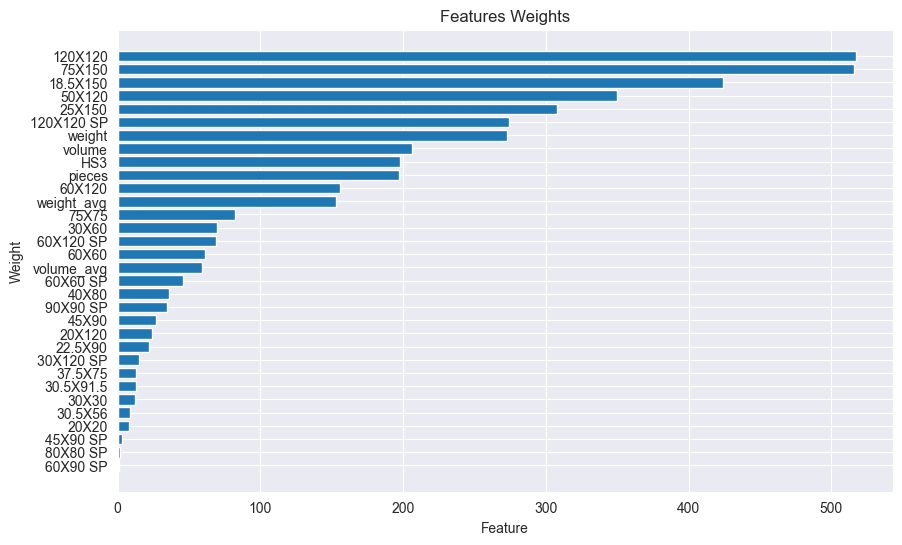

In [76]:
plot_feat_group(size_feat, 'Feature', 'Weight', 'Features Weights')

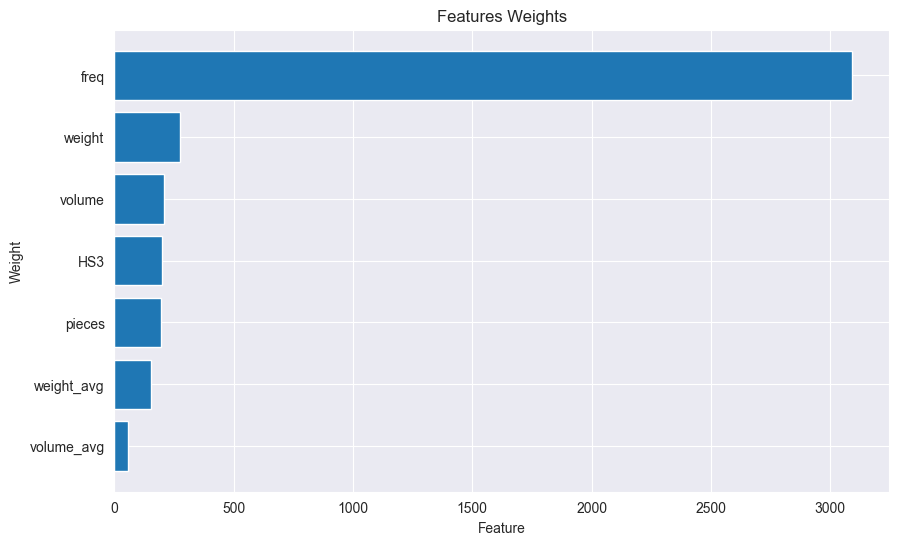

In [77]:
plot_feat_group(unit_feat, 'Feature', 'Weight', 'Features Weights')

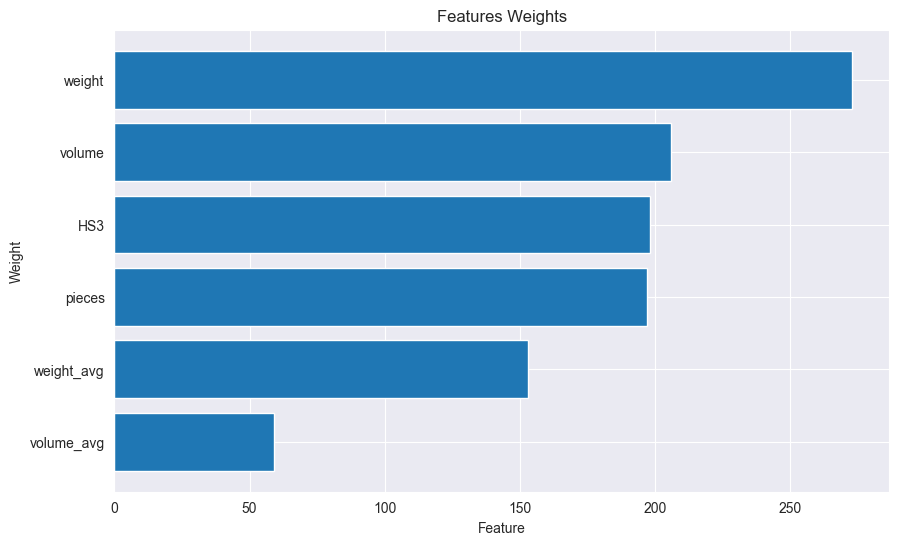

In [78]:
plot_feat_group(second_size_feat, 'Feature', 'Weight', 'Features Weights')

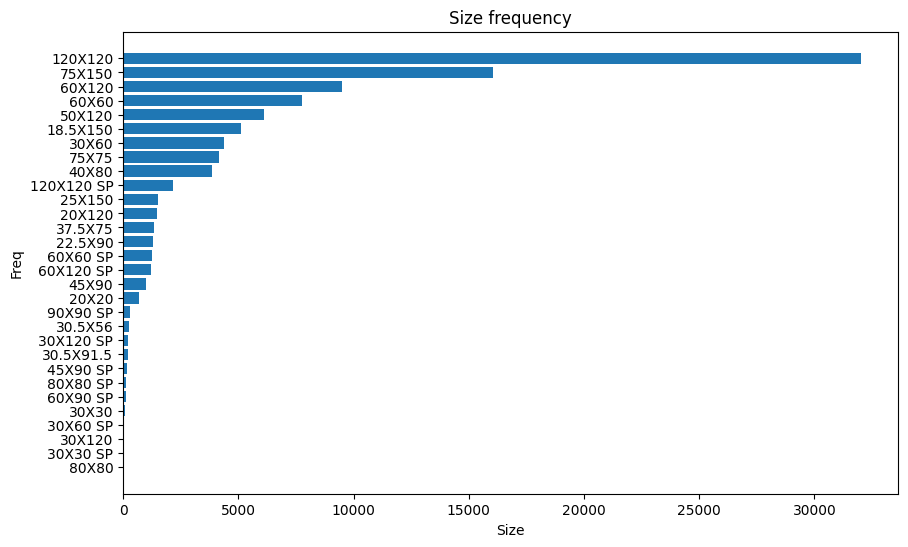

In [225]:
size_freq = {}

for sz in item_sizes:
    if sz not in current_sizes:
        continue
    size_freq[sz] = int((train_input[sz] > 0).sum())

plot_feat_group(size_freq, 'Size', 'Freq', 'Size frequency')

In [79]:
import matplotlib.pyplot as plt

def plot_two_feat(features, feat_names):

    # Sort the keys and values by the first feat
    sorted_items = sorted(features.items(), key=lambda item: item[1][0])
    sorted_keys = [item[0] for item in sorted_items]
    sorted_feat = [
        np.array([item[1][0] for item in sorted_items]),
        np.array([item[1][1] for item in sorted_items])
    ]

    # Normalize values
    norm_feat = [
        sorted_feat[0] / np.max(sorted_feat[0]),
        sorted_feat[1] / np.max(sorted_feat[1])
    ]

    df = pd.DataFrame({feat_names[1]: norm_feat[1], feat_names[0]: norm_feat[0]}, index=sorted_keys)
    res = df.plot.barh(figsize=(12, 10), title=f"{feat_names[0]} vs {feat_names[1]} (normalized)").get_figure()
    # res.savefig('mse-vs-freq.png', bbox_inches='tight')

size_freq_weight = {}

for sz in item_sizes:

    if sz not in current_sizes:
        continue
    
    weight = size_feat.get(sz, 0)
    freq = size_freq.get(sz, 0)
    size_freq_weight[sz] = (weight, freq)

plot_two_feat(size_freq_weight, feat_names=["Feature weight", "Frequency"])

NameError: name 'size_freq' is not defined

In [226]:
y_predict = model.predict(X_test)
y_predict = np.round(y_predict).astype(int)

diff_df = pd.DataFrame({
    'y_test': y_test,
    'y_predict': y_predict,
    'difference': y_test - y_predict,
    'abs_difference': abs(y_test - y_predict),
    'perc_difference': 100 * abs(y_test - y_predict) / y_test
})

df_sorted = diff_df.sort_values(by='abs_difference', ascending=False).reset_index()
df_sorted

,index,y_test,y_predict,difference,abs_difference,perc_difference
0,1034,11,20,-9,9,81.818182
1,4288,27,19,8,8,29.629630
2,4261,13,5,8,8,61.538462
3,4739,30,23,7,7,23.333333
4,4198,11,4,7,7,63.636364
...,...,...,...,...,...,...
5598,5581,5,5,0,0,0.000000
5599,5580,2,2,0,0,0.000000
5600,5578,2,2,0,0,0.000000
5601,5577,2,2,0,0,0.000000


In [227]:
indexes = df_sorted.head(10)['index'].to_numpy()

bad_cases = test_input.iloc[indexes]
bad_cases

,errors,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS2,weight_avg,volume_avg,HS1,pallets_extra_used
OBD0000491643,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,662.0,0.0,0.0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1462.0,23464.00,1.057752e+10,22.0,16.049248,7.234966e+06,19.0,11
OBD0000616358,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,525.0,0.0,0.0,0.0,1005.0,16266.40,7.380000e+09,27.0,16.185473,7.343284e+06,13.0,27
OBD0000595939,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0,17495.00,7.459200e+09,15.0,64.796296,2.762667e+07,14.0,13
OBD0000589857,0,0,0,0.0,0.0,0.0,0.0,0.0,372.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,782.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1784.0,28610.66,1.245456e+10,36.0,16.037365,6.981256e+06,23.0,30
OBD0000922469,0,0,0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0,18408.92,7.931520e+09,16.0,33.229097,1.431682e+07,15.0,11
OBD0000573341,0,0,0,0.0,0.0,0.0,0.0,0.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1341.0,30525.75,1.344816e+10,30.0,22.763423,1.002846e+07,24.0,10
OBD0000616407,0,0,0,0.0,0.0,320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0,0.0,0.0,0.0,0.0,0.0,2436.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3044.0,20849.81,9.460710e+09,25.0,6.849478,3.107986e+06,17.0,24
OBD0000802633,0,0,0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1680.0,8528.85,3.993300e+09,11.0,5.076696,2.376964e+06,7.0,13
OBD0000810301,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,0.0,0.0,206.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,512.0,24143.06,1.033920e+10,20.0,47.154414,2.019375e+07,19.0,1
OBD0000333706,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.0,9723.76,4.150080e+09,9.0,63.141299,2.694857e+07,8.0,8


In [228]:
def count_tile_types(row):
    cnt = 0
    for size in item_sizes:
        if size not in current_sizes:
            continue
        if row[size] > 0:
            cnt += 1
    return cnt

bad_cases_num_tiles = bad_cases.apply(count_tile_types, axis=1)
bad_cases_num_tiles

OBD0000491643    2
OBD0000616358    2
OBD0000595939    2
OBD0000589857    3
OBD0000922469    3
OBD0000573341    3
OBD0000616407    3
OBD0000802633    2
OBD0000810301    2
OBD0000333706    2
dtype: int64

In [229]:
num_tiles = np.array(test_input.apply(count_tile_types, axis=1))
diff = diff_df['difference'].to_numpy()
abs_diff = diff_df['abs_difference'].to_numpy()

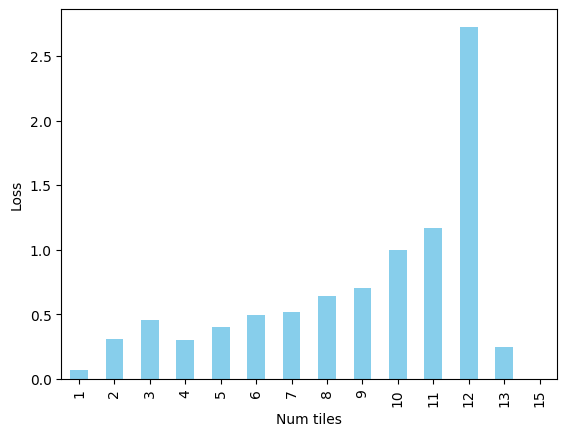

In [230]:
from sklearn.metrics import mean_squared_error

num_tiles_diff_df = pd.DataFrame({'num_tiles': num_tiles, 'y_test': y_test, 'y_predict': y_predict})
loss_by_tiles = num_tiles_diff_df.groupby('num_tiles').apply(lambda x: mean_squared_error(x['y_test'], x['y_predict']), include_groups=False)

loss_by_tiles.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Num tiles')
plt.ylabel('Loss')

plt.show()

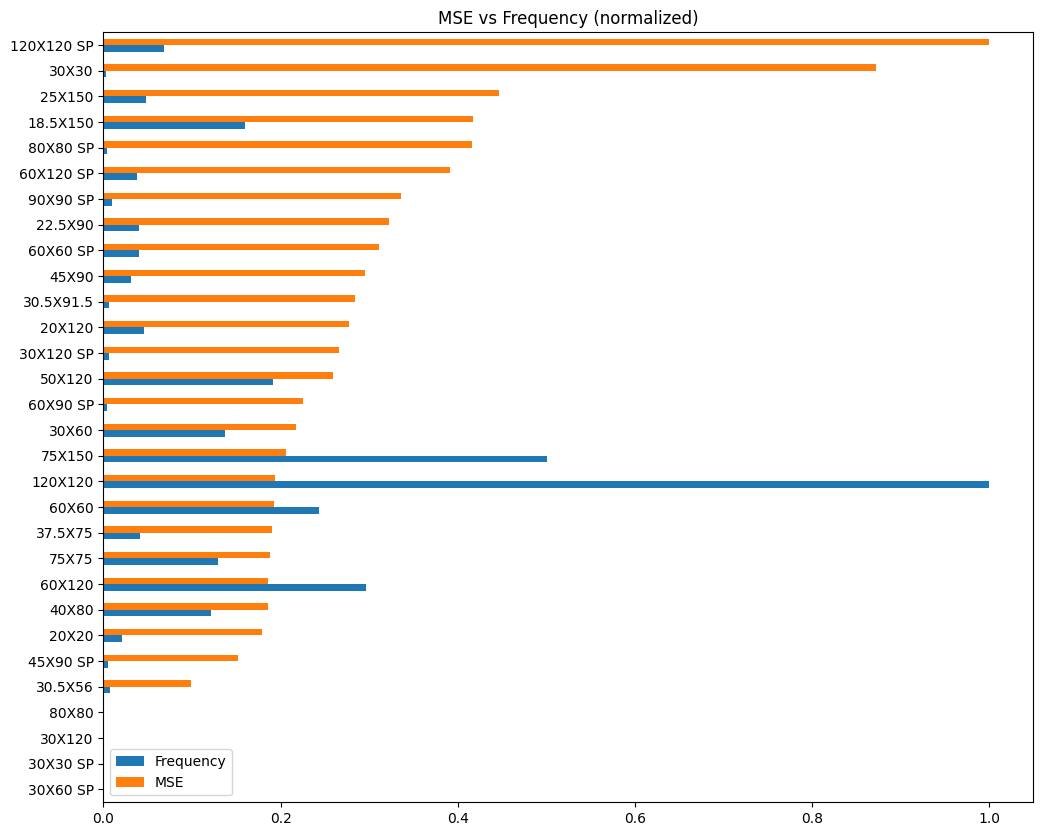

In [232]:
from sklearn.metrics import mean_squared_error

test_input_pred = test_input.copy()
test_input_pred['predict'] = y_predict

loss_by_size = {}

for sz in item_sizes:
    if sz not in current_sizes:
        continue
    test_input_size = test_input_pred[test_input_pred[sz] > 0]
    if len(test_input_size) > 0:
        loss_by_size[sz] = mean_squared_error(test_input_size['pallets_extra_used'], test_input_size['predict'])

size_freq_loss = {}

for sz in item_sizes:

    if sz not in current_sizes:
        continue
    
    loss = loss_by_size.get(sz, 0)
    freq = size_freq.get(sz, 0)
    size_freq_loss[sz] = (loss, freq)

plot_two_feat(size_freq_loss, feat_names=["MSE", "Frequency"])

In [233]:
orders_df[orders_df['order_number'] == 'OBD0000588543']

,order_number,item_id,item,item_size,batch,pieces,full_order,homogeneous_order,row_produce_only_full,row_produce_only_pick
12138,OBD0000588543,69972c3cfc N 035,69972c3cfc,60X120,1 DF4 5,70,0,0,1,0
34300,OBD0000588543,ec3ef31bde S 036,ec3ef31bde,"22,5X90",1 BN6 6=,252,0,0,1,0
106658,OBD0000588543,69972c3cfc N 035,69972c3cfc,60X120,1 DF3 5,70,0,0,1,0
135723,OBD0000588543,78b7f2e336 S 036,78b7f2e336,"22,5X90",1 BB6 6=,252,0,0,1,0
349024,OBD0000588543,78b7f2e336 S 036,78b7f2e336,"22,5X90",1 BB6 6=,224,0,0,0,1


In [154]:
output_df[output_df['order_number'] == 'OBD0000588543']

,order_number,pallet_id,pallet_type,full_pallet,item,item_size,batch,pieces,homogeneous_order,full_order
12601,OBD0000588543,51448185,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12602,OBD0000588543,51448186,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12603,OBD0000588543,51448217,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12604,OBD0000588543,51448221,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12605,OBD0000588543,51451628,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12606,OBD0000588543,51451632,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12607,OBD0000588543,51451697,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12608,OBD0000588543,51451843,B,1,ec3ef31bde,"22,5X90",1 BN6 6=,"252,0",0,0
12609,OBD0000588543,51885648,B,1,78b7f2e336,"22,5X90",1 BB6 6=,"252,0",0,0
12610,OBD0000588543,51885694,B,0,78b7f2e336,"22,5X90",1 BB6 6=,"224,0",0,0


In [155]:
order_items_attr[order_items_attr['order'] == 'OBD0000588543']

,errors,order,homogeneous_order,full_order,30X30,20X20,30X60,60X60,22.5X90,60X120,45X90,75X75,30.5X56,30.5X91.5,60X60 SP,40X80,30X60 SP,45X90 SP,75X150,25X150,30X120 SP,120X120,60X120 SP,30X30 SP,18.5X150,120X120 SP,37.5X75,90X90 SP,20X120,60X90 SP,50X120,80X80 SP,30X120,80X80,pieces,weight,volume,HS2
12138,0,OBD0000588543,0,0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1050.0,453600000.0,1.0
34300,0,OBD0000588543,0,0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,900.0,408240000.0,1.0
106658,0,OBD0000588543,0,0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1050.0,453600000.0,1.0
135723,0,OBD0000588543,0,0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,864.0,408240000.0,1.0
349024,0,OBD0000588543,0,0,0.0,0.0,0.0,0.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224.0,768.0,362880000.0,1.0


In [156]:
items_df[items_df['item'] == 'ec3ef31bde']

,item_id,item,defom,exsz,schpl,x_mm,y_mm,z_mm,pzxsc,kgxsc,x_sc_mm,y_sc_mm,z_sc_mm,scxfrd,frdxplt,x_frd_mm,y_frd_mm,z_frd_mm,kgxfrd,cdsup,scxpl,z_cub_mm,x_pal_mm,y_pal_mm,kgxplt,z_pal_mm
1829,ec3ef31bde S 036,ec3ef31bde,22.5X90,0,S 036,225,900,8,7,25.0,225,900,56.0,2.0,18,225,900,128.8,50.0,B,36,446,1010,1200,900.0,134
